# Natures Eye

## Introduction

Technological pursuit has been fundamental to human prospering  since the beginning. From Prometheus bringing fire, to Loki crafting the first net, we have mythologised the technological progress. However we are feeble creatures and our pursuits are imperfect. With technology, We are as new lovers. All eager innocence and elbows. Our attempts to connect through social networks, have created more alienation. Our cure of hunger has created an epidemic of obesity. Indeed, even Prometheus ended chained to a rock, and Loki ensnared the the very net he invented. We are no longer what we were, we were born in the changing tide of advancement. Now is the time for a mature stance on progress.
We must make things fit us, not make us, fit the things we make. This leads me to introduce Nature’s Eye
It is an educational app that will allow users to interact with what they see.
The general idea is that users will be able to take a picture, initially of an animal. 
And a model will identify the animal, then link useful educational information related to what was identified.

### Import Libraries and Define Functions

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from matplotlib.image import imread 
from PIL import Image

# Neural network libraries

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, losses, metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
np.random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

%matplotlib inline

import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

from keras.layers.convolutional import Conv2D
from keras.layers import Activation, Dense

In [15]:
def show_metrics(history):
    results = history.history
    plt.figure()
    plt.plot(results['val_accuracy'], label = 'Validation Accuracy')
    plt.plot(results['accuracy'], label = 'Train Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show();
    
    plt.figure()
    plt.plot(results['val_recall'], label = 'Validation Recall')
    plt.plot(results['recall'], label = 'Train Recall')
    plt.title('Recall Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show();
    
    plt.figure()
    plt.plot(results['val_loss'], label = 'Validation Loss')
    plt.plot(results['loss'], label = 'Train Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show();

In [16]:
# Create function to display confusion matrices for models
def conf_mat(model):
    y_pred = model.predict(test_set)
    y_pred = (y_pred>0.5).astype(np.int)
    display(ConfusionMatrixDisplay(confusion_matrix(test_set.classes, y_pred), display_labels=['Normal', 'Pneumonia']).plot())

In [17]:
# function for the showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.in_layer(out)
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        out = self.out_layer(F.relu(out))
        return out

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

## Data Understanding

I chose a data set with 5000 images of 90 different animals, from Kaggle
There is a lack of data with  only 60 instances of each class. This is the primary limit of the data. I will need to collect more photos to compensate for  this.
This data is useful because it has already been labeled with the class of animal and will reduce preprossing time.
Since the data is just an image and is associated class, all the data will be included.

To access this data go to https://www.kaggle.com/iamsouravbanerjee/animal-image-dataset-90-different-animals and download the data set. Put it in the folder with your enviroment and the code should run.

### Data Loading

First load the data in. Because of the size, this may take a while.

In [23]:
#train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
train_path = 'archive/animals'

#Get all the data in the directory data/validation (624 images), and reshape them
#test_generator = ImageDataGenerator().flow_from_directory(
#       test_data_dir, 
#       target_size=(64, 64), batch_size=624, color_mode='grayscale', class_mode='binary')

#Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_path, 
       target_size=(64, 64), color_mode='rgb', class_mode='categorical')

#Create the datasets
train_images, train_labels = next(train_generator)
#test_images, test_labels = next(test_generator)

Found 5400 images belonging to 90 classes.


In [24]:
#train_labels[:10]
train_labels[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

Here is a list of the classes of animals.

In [25]:
train_generator.class_indices

{'antelope': 0,
 'badger': 1,
 'bat': 2,
 'bear': 3,
 'bee': 4,
 'beetle': 5,
 'bison': 6,
 'boar': 7,
 'butterfly': 8,
 'cat': 9,
 'caterpillar': 10,
 'chimpanzee': 11,
 'cockroach': 12,
 'cow': 13,
 'coyote': 14,
 'crab': 15,
 'crow': 16,
 'deer': 17,
 'dog': 18,
 'dolphin': 19,
 'donkey': 20,
 'dragonfly': 21,
 'duck': 22,
 'eagle': 23,
 'elephant': 24,
 'flamingo': 25,
 'fly': 26,
 'fox': 27,
 'goat': 28,
 'goldfish': 29,
 'goose': 30,
 'gorilla': 31,
 'grasshopper': 32,
 'hamster': 33,
 'hare': 34,
 'hedgehog': 35,
 'hippopotamus': 36,
 'hornbill': 37,
 'horse': 38,
 'hummingbird': 39,
 'hyena': 40,
 'jellyfish': 41,
 'kangaroo': 42,
 'koala': 43,
 'ladybugs': 44,
 'leopard': 45,
 'lion': 46,
 'lizard': 47,
 'lobster': 48,
 'mosquito': 49,
 'moth': 50,
 'mouse': 51,
 'octopus': 52,
 'okapi': 53,
 'orangutan': 54,
 'otter': 55,
 'owl': 56,
 'ox': 57,
 'oyster': 58,
 'panda': 59,
 'parrot': 60,
 'pelecaniformes': 61,
 'penguin': 62,
 'pig': 63,
 'pigeon': 64,
 'porcupine': 65,
 'pos

## dummy classifer/regressor for baseline

Here I created a dummy classifier, just for a point of comparison. It had a accuracy score of 0. I will create better models using Neural Networks.

In [70]:
#dummy classifer/regressor for baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='uniform')
dummy.fit(trainx, trainy)

DummyClassifier(strategy='uniform')

In [73]:
dummy.score(testx, testy)

0.0

In [75]:
dummy.predict(testy)

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.]], dtype=float32)

## Data Manipulation

Here is a link to the most useful source I found for making these models https://towardsdatascience.com/convolution-neural-network-for-image-processing-using-keras-dc3429056306

Here I learned much of the syntax and conceptual framework for the following model and data manipulation.

In [27]:
#conda install pytorch torchvision cpuonly -c pytorch

In [28]:
#conda update -n base -c defaults conda

In [29]:
data_dir = 'archive/animals'
classes = os.listdir(data_dir)

Transform the data

By rotating and flipping the images, I am able to generate more data for the model to train on and improve its accuracy.

In [30]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(100),             # resize shortest side to 100 pixels
        transforms.CenterCrop(100),         # crop longest side to 100 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [31]:
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 5400


In [32]:
# view one image shape of the dataset.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 100, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  bear (3)


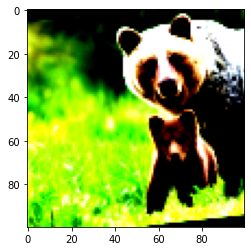

In [33]:
show_image(*dataset[200])

In [34]:
torch.manual_seed(20)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size -test_size

Split the data.

In [35]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(3780, 540, 1080)

In [36]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

Let's take a look a the images inside.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


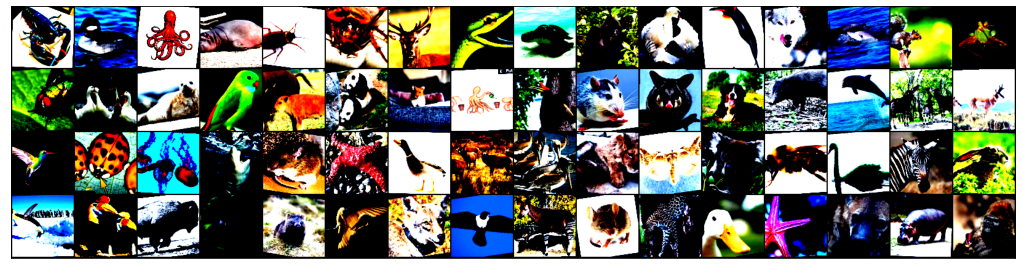

In [37]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [38]:
torch.cuda.is_available()

False

In [39]:
device = get_default_device()
device

device(type='cpu')

Use a previously defined function to get the data ready for my first model.

In [40]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [41]:
input_size = 3*100*100
output_size = 91 # Number of classes

## Linear Model

First I instantiate a neural network.

In [42]:
model = to_device(Model(input_size, output_size), device)

In [43]:
model

Model(
  (in_layer): Linear(in_features=30000, out_features=8384, bias=True)
  (hidden1): Linear(in_features=8384, out_features=4192, bias=True)
  (hidden2): Linear(in_features=4192, out_features=2096, bias=True)
  (hidden3): Linear(in_features=2096, out_features=1048, bias=True)
  (out_layer): Linear(in_features=1048, out_features=91, bias=True)
)

I use a function defined earlier to compile the model.

In [44]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 4.512565612792969, 'val_acc': 0.004687500186264515}]

Then I fit it to the data.

In [45]:
history += fit(7, 0.01, model, train_loader, val_loader)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.5081, val_loss: 4.5065, val_acc: 0.0203


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4978, val_loss: 4.4980, val_acc: 0.0250


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.4850, val_loss: 4.4895, val_acc: 0.0243


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.4663, val_loss: 4.4778, val_acc: 0.0259


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.4404, val_loss: 4.4569, val_acc: 0.0275


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.4069, val_loss: 4.4332, val_acc: 0.0393


100%|██████████| 60/60 [01:48<00:00,  1.81s/it]


Epoch [6], train_loss: 4.3636, val_loss: 4.4053, val_acc: 0.0393


I try altering the learning rate to see if I can improve accuracy.

In [46]:
history += fit(4, 0.001, model, train_loader, val_loader)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.3240, val_loss: 4.3991, val_acc: 0.0368


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.3211, val_loss: 4.3956, val_acc: 0.0337


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.3094, val_loss: 4.3906, val_acc: 0.0368


100%|██████████| 60/60 [01:46<00:00,  1.77s/it]


Epoch [3], train_loss: 4.3071, val_loss: 4.3860, val_acc: 0.0337


Lowering the learning rate seems to be working, so I will lower it again.

In [47]:
history += fit(3, 0.0001, model, train_loader, val_loader)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.2959, val_loss: 4.3854, val_acc: 0.0321


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.3017, val_loss: 4.3869, val_acc: 0.0337


100%|██████████| 60/60 [01:49<00:00,  1.82s/it]


Epoch [2], train_loss: 4.2933, val_loss: 4.3856, val_acc: 0.0321


It appears that I do not gain much accuracy after about 6 epochs.

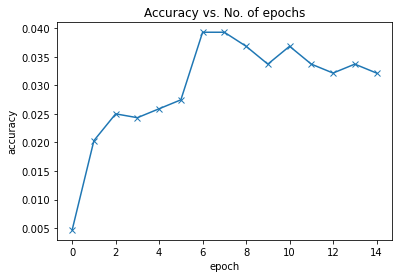

In [48]:
plot_accuracies(history)

Here it shows I gain little after 8 epochs.

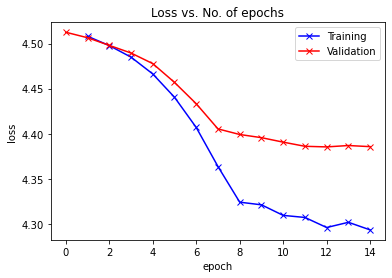

In [49]:
plot_losses(history)

An accuracy of less than 4% is not ideal. But I didn't expect much with a linear activation funciton.

In [50]:
evaluate(model, test_loader)

{'val_loss': 4.352909564971924, 'val_acc': 0.0365823395550251}

## Dense Net - Final Model

I wasn't having much success with the previous model, even after altering learning rates and other parameter, so I tried something different.

In [51]:
#pip install opencv-python

Just make sure I know what I'm working with.

In [52]:
Name = os.listdir(data_dir)
print(Name)
print(len(Name))

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']
90


In [53]:
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

Resize the data for the new model. - Ran into errors, this was the easiest solution.

In [54]:
dataX=[]
dataY0=[]
count=0
for name in tqdm(os.listdir(data_dir)):
    path=os.path.join(data_dir,name)
    for im in os.listdir(path):
        image=cv2.imread(os.path.join(path,im))
        if type(image)==np.ndarray:
            sp=image.shape
            image2=image[(sp[0]//3):(sp[0]*2//3),(sp[1]//3):(sp[1]*2//3),:]
            image3=cv2.resize(image2,dsize=(32,32),interpolation=cv2.INTER_CUBIC)
            dataX+=[image3]
            dataY0+=[count]
    count=count+1

100%|██████████| 90/90 [00:54<00:00,  1.66it/s]


In [55]:
m=len(dataX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

dataX=np.array(dataX)
dataY0=np.array(dataY0)

trainX=dataX[M[0:(m//4)*3]]
trainY0=dataY0[M[0:(m//4)*3]]

testX=dataX[M[(m//4)*3:]]
testY0=dataY0[M[(m//4)*3:]]

In [56]:
labels1=to_categorical(trainY0)
trainY=np.array(labels1)

In [57]:
trainX=np.array(trainX)
testX=np.array(testX)

Split the data into train and test sets.

In [58]:
trainx,testx,trainy,testy=train_test_split(trainX,trainY,test_size=0.2,random_state=44)

Rename data for this model.

In [59]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

First I instantiate the Model. The previously linked source above suggested using relu as the activation function.

In [60]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

In [61]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(len(Name), activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

Then I compile the Model.

In [62]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Then I fit the model.

In [63]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=10)

Epoch 1/10
102/102 [==============================] - 17s 167ms/step - loss: 4.6678 - accuracy: 0.0256 - val_loss: 4.4215 - val_accuracy: 0.0198
Epoch 2/10
102/102 [==============================] - 14s 140ms/step - loss: 4.3226 - accuracy: 0.0562 - val_loss: 4.3339 - val_accuracy: 0.0506
Epoch 3/10
102/102 [==============================] - 14s 139ms/step - loss: 4.1624 - accuracy: 0.0741 - val_loss: 4.3608 - val_accuracy: 0.0580
Epoch 4/10
102/102 [==============================] - 14s 140ms/step - loss: 4.0270 - accuracy: 0.0901 - val_loss: 4.3879 - val_accuracy: 0.0642
Epoch 5/10
102/102 [==============================] - 14s 139ms/step - loss: 3.8821 - accuracy: 0.1006 - val_loss: 4.4050 - val_accuracy: 0.0753
Epoch 6/10
102/102 [==============================] - 14s 141ms/step - loss: 3.7758 - accuracy: 0.1259 - val_loss: 4.2368 - val_accuracy: 0.0963
Epoch 7/10
102/102 [==============================] - 14s 139ms/step - loss: 3.6914 - accuracy: 0.1373 - val_loss: 4.4615 - val_ac

Here I can see that I get up to an accuracy score of 11%

In [64]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        10
           4       0.08      0.57      0.15         7
           5       0.08      0.09      0.09        11
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         6
           8       0.17      0.36      0.24        11
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         8
          11       0.11      0.11      0.11         9
          12       0.38      0.25      0.30        12
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         5
          16       0.20      0.11      0.14         9
          17       0.00    

C:\Users\danie\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Lets take a look at how the model performed. It appears to a have peaked at around 13%. Also it doesn't gain much after 6 epochs. However, this is the improvement over the last model I was looking for.

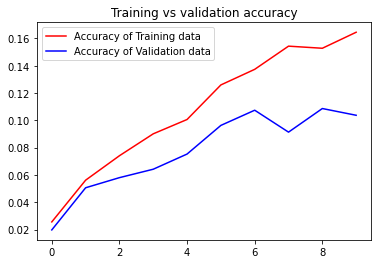

<Figure size 432x288 with 0 Axes>

In [65]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

Here we can see that the model stops minimizing loss almost imediately.

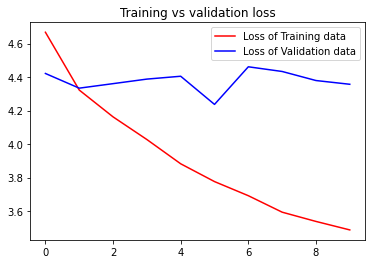

<Figure size 432x288 with 0 Axes>

In [66]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Just a quick glance shows my model isn't performing particualy well. It doesn't look like any of the predicitions are accurate.

In [67]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

(1350, 90)
65    255
53     84
45     74
7      63
4      60
     ... 
43      1
15      1
40      1
33      1
0       1
Length: 77, dtype: int64


In [68]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.09185185185185185


Lets view some predictions. 
Looking at them I can see that none of the predictions were accurate.

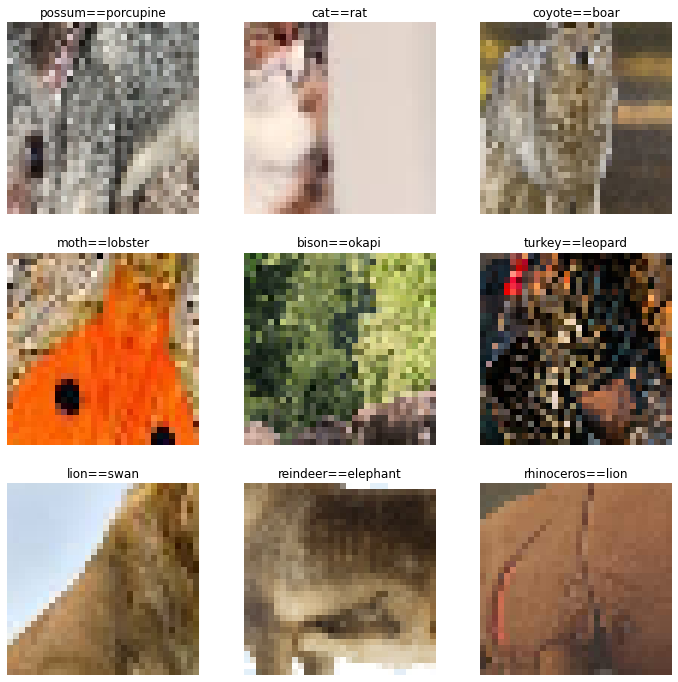

In [69]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[i]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[ANS[i]]
    predict=reverse_mapping[PRED[i]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

## Evaluation

I will be using the accuracy metric, because of the low cost of false positives.
My final Model is the Dense Net, which had an accuracy score of 13% on training data
The model had an accuracy of 11% on testing data
This Model is not good enough for it to be deployed. It first needs to be improved

## Conclusion - Evalution

My current best model has an accuracy under 14%. I am using accuracy, because the cost of false positives is low. This is below the threshold necessary for it to function reasonably in the world. I need to collect much more data to improve the model.
First, I going to get more data, this is clearly a huge reason that my model is less accurate than i would like
Next, I would like to radically expand the domain of the model, to incorporate more animals as well as plants, stars, even famous artwork and architecture
Finally, when the model is performing at a non comedic level, I will create an app, so that people will have access